In [1]:
import pandas as pd

import urllib.request
import zipfile

from collections import Counter

In [2]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [3]:
def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file and read it into a pandas 
    DataFrame
    Parameters:
        src (str): URL of the zip file to be downloaded and extracted.
        dst (str): Local file path where the zip file will be written.
        member_name (str): Name of the member file inside the zip file 
            to be read into a DataFrame.
    
    Returns:
        pandas.DataFrame: DataFrame containing the contents of the 
            member file.
    """    
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
    return raw

In [4]:
raw = extract_zip(url, fname, member_name)

C:\Users\rhg22\AppData\Local\Temp\ipykernel_16260\58667168.py:21: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))


This data comes from a Kaggle survey conducted in 2018 1. As part of the survey, Kaggle asked users about a wide range of topics, from what kind of machine learning software they use to how much money they make. We’re going to be using the responses from the survey to predict what kind of job the respondent has.

https://www.kaggle.com/datasets/kaggle/kaggle-survey-2018

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23859 entries, 1 to 23859
Columns: 395 entries, Time from Start to Finish (seconds) to Q50_OTHER_TEXT
dtypes: object(395)
memory usage: 71.9+ MB


In [6]:
raw.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


In [7]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """    
    return (
        df_
        .assign(
            age=df_.Q2.str.slice(0,2).astype(int),
            education=df_.Q4.replace({
                'Master’s degree': 18,
                'Bachelor’s degree': 16,
                'Doctoral degree': 20,
                'Some college/university study without earning a bachelor’s degree': 13,
                'Professional degree': 19,
                'I prefer not to answer': None,
                'No formal education past high school': 12
            }),
            major=(
                df_.Q5
                .pipe(topn, n=3)
                .replace({
                    'Computer science (software engineering, etc.)': 'cs',
                    'Engineering (non-computer focused)': 'eng',
                    'Mathematics or statistics': 'stat'
                })
            ),
            years_exp=(
                df_.Q8.str.replace('+','', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .astype(float)
            ),
            compensation=(
                df_.Q9.str.replace('+','', regex=False)
                .str.replace(',','', regex=False)
                .str.replace('500000', '500', regex=False)
                .str.replace('I do not wish to disclose my approximate yearly compensation', '0', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .fillna(0)
                .astype(int)
                .mul(1_000)
            ),
            python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
            r=df_.Q16_Part_2.fillna(0).replace('R', 1),
            sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
        )  # assign
        .rename(columns=lambda col: col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,python,r,sql'.split(',')]
    )

In [8]:
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

**Note**

`The capitalization on X is meant to indicate that the data is a matrix and two-dimensional, while the lowercase y is a one-dimensional vector. If you are familiar with linear algebra, you might recognize these conventions, capital letters for matrices and lowercase for vectors.`

In [9]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [10]:
class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """
    
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_kag(X)
    
    def fit(self, X, y=None):
        return self

The get_rawX_y function will take the original data and return an X DataFrame and a y Series ready to feed into our pipeline for further cleanup. It uses the .query method of Pandas to limit the rows to only those located in the US, China, or India, and respondents that had the job title of Data Scientist or Software Engineer.

Below that, a pipeline is stored in the variable kag_pl. The pipeline will process the data by calling the TweakKagTransformer. Then it will perform one hot encoding on the Q1, Q3, and major columns using the Feature Engine library. Finally, it will use the imputation library to fill in missing numeric values in the education and year_exp columns. It does that by filling in the missing values with the median values.

In [11]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]

In [12]:
## Create a pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
     ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True, 
           variables=['Q1', 'Q3', 'major'])),
     ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
          variables=['education', 'years_exp']))]
)

**Note**

``The stratify parameter of the train_test_split function is important because it ensures that the proportion of different classes found in the labels of in the dataset is maintained in both the training and test sets. This is particularly useful when working with imbalanced datasets, where one class may be under-represented. Without stratification, the training and test sets may not accurately reflect the distribution of classes in the original dataset, which can lead to biased or unreliable model performance.``


``For example, if we have a binary classification problem, where the dataset has 80% class A and 20% class B, if we stratify, we will split the data into training and test sets. We will have 80% class A and 20% class B in both sets, which helps to ensure that the classifier will generalize well to unseen data. If we don’t stratify, it is possible to get all of class B in the test set, hampering the ability of the model to learn class B.
To use stratification, you pass in the labels to the stratify parameter.``

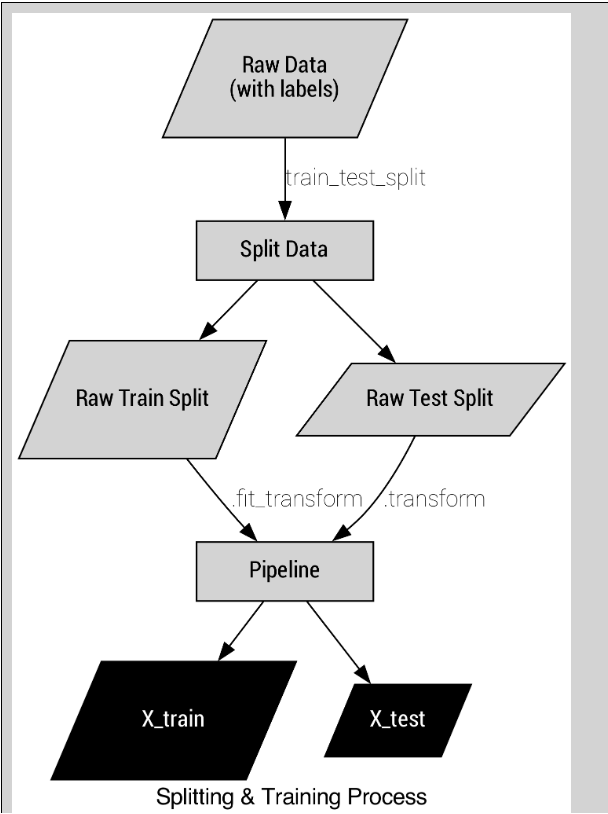

In [13]:
from sklearn import model_selection

In [14]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [15]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [16]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male   
587     25       18.0        4.0             0       1  0    1        1  \
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe   
587            0             

In [17]:
Counter(kag_y_train)

Counter({'Software Engineer': 957, 'Data Scientist': 1153})

# Exploratory Data Analysis

## Correlations

In [18]:
(X_train
 .assign(data_scientist = kag_y_train == 'Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


## Bar Plot

Here’s what the code is doing line by line:

- Start with the X_train dataframe
- Create a data_scientist column
- Group by the r column
- Look only at the data_scientist column
- Get the counts for each different entry in the data_scientist column (which will be represented as a multi-index)
- Pull out the data_scientist level of the multi-index and put it in the columns
- Create a bar plot from each column (data_scientist options) for each entry in r

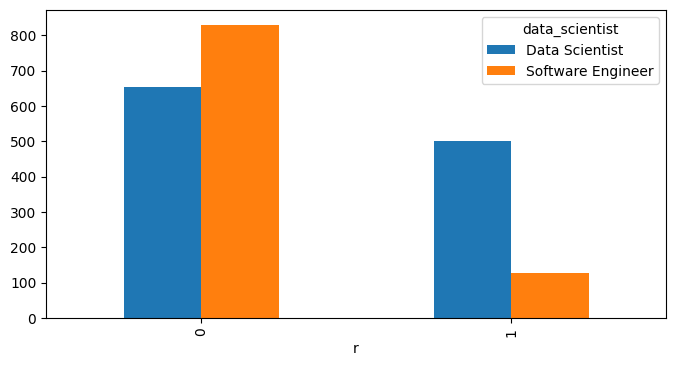

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

(X_train
 .assign(data_scientist = kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)
);

It turns out that the column with the most negative correlation to job title (-0.31) was also an indicator column, major_cs, indicating whether the respondent studied computer science. Let’s explore using the cross-tabulation function (pd.crosstab) which provides a helper function for the previous chain of Pandas code.

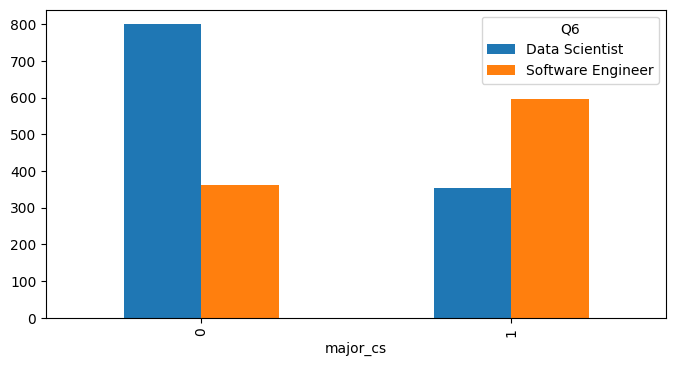

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=X_train['major_cs'], 
             columns=kag_y)
    .plot.bar(ax=ax)
);

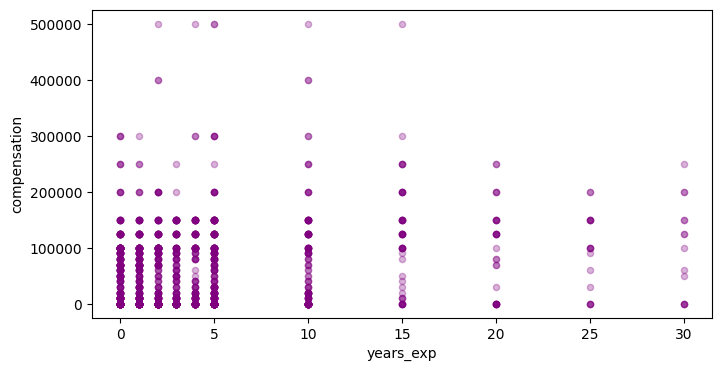

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
);

This plot is ok, but it is glaringly evident that the data is binned. In the real-world folks would only have exactly five years of experience on one day. Luckily, we set the alpha transparency to see where points pile up on top of each other. But given the plot, it is hard to tell what is going on.
I’m going to use the Seaborn library to create a plot that is more involved. One thing I want to do is add jitter. Because our points land on top of each other, it is hard to understand the density. If we shift each one horizontally and vertically (called jitter) by a different random amount, it will aid with that. (This is done with so.Jitter(x=.5, y=10_000)

I’m also going to color the points by the title. (color='title')

Finally, we will fit a polynomial line through the points to see the trend. (see .add(so.Line(), so.PolyFit()))

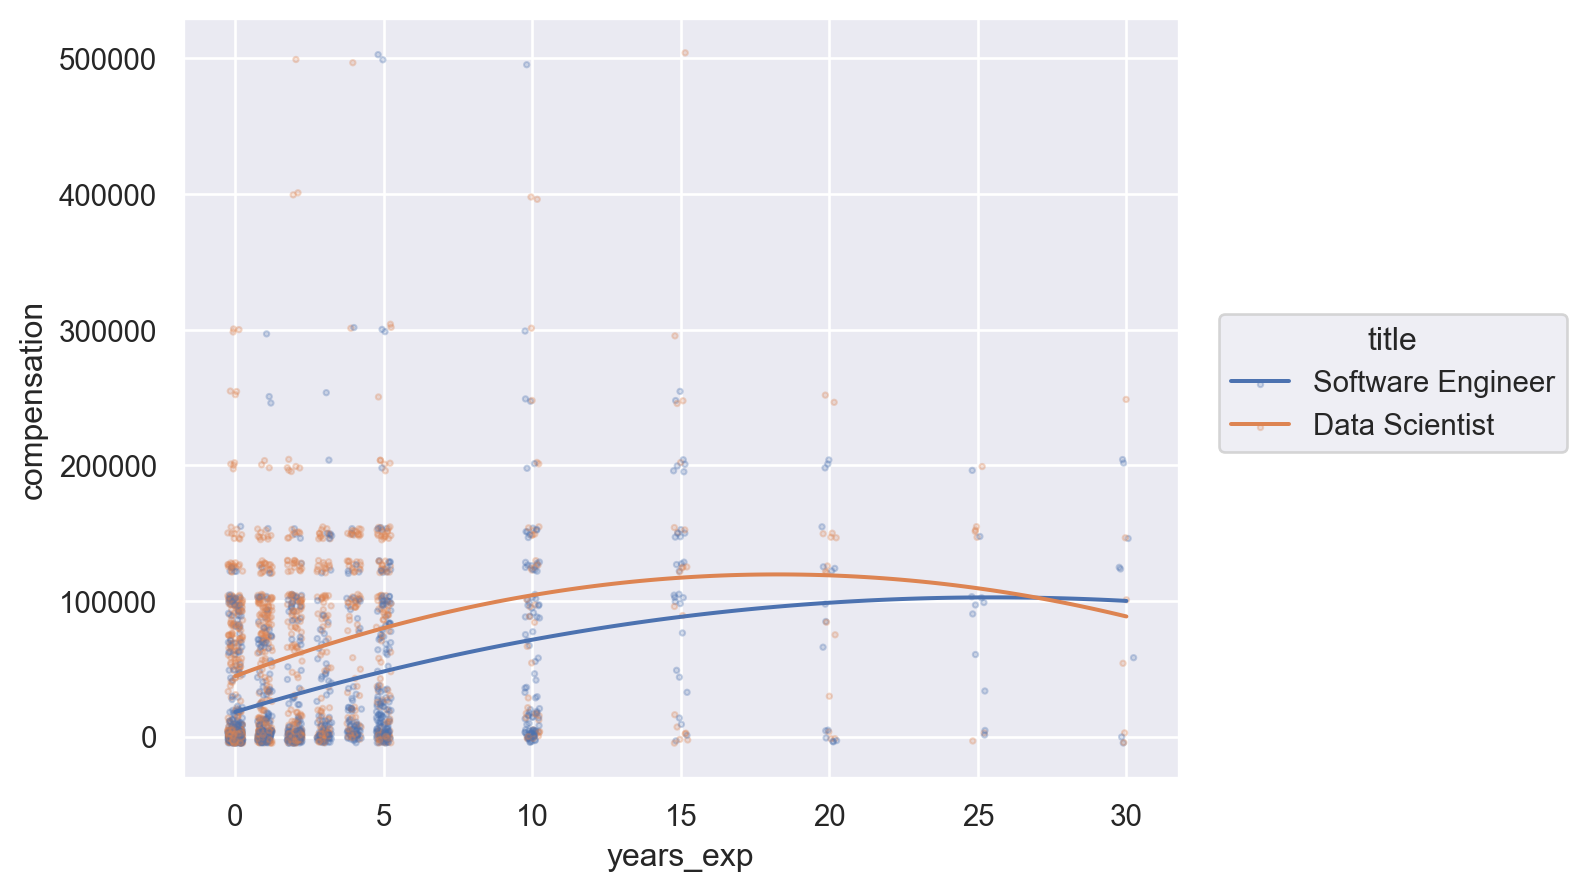

<Figure size 800x400 with 0 Axes>

In [22]:
import seaborn.objects as so

fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
 .add(so.Line(), so.PolyFit())
#  .on(fig)  # not required unless saving to image
#  .plot()   # ditto
)

This plot is more interesting. It indicates that data scientists tend to earn more than their software engineer counterparts. This hints that compensation might come in useful for determining job titles.
Another point to consider is that this plot lumps together folks from around the world. Different regions are likely to compensate differently. Let’s tease that apart as well.

Another point to consider is that this plot lumps together folks from around the world. Different regions are likely to compensate differently. Let’s tease that apart as well.
This next plot is cool. The Seaborn objects interface makes it simple to facet the data by country (.facet('country')). 

Also, I want to show all of the data in grey on each plot. If you set col=None, it will plot all of the data. However, I want to zoom into to lower left corner because most of the data is found there. I can adjust the tick locations with .scale(x=so.Continuous().tick(at=[0,1,2,3,4,5])) and adjust the limit as well with .limit(y=(-10_000, 200_000), x=(-1, 6)).

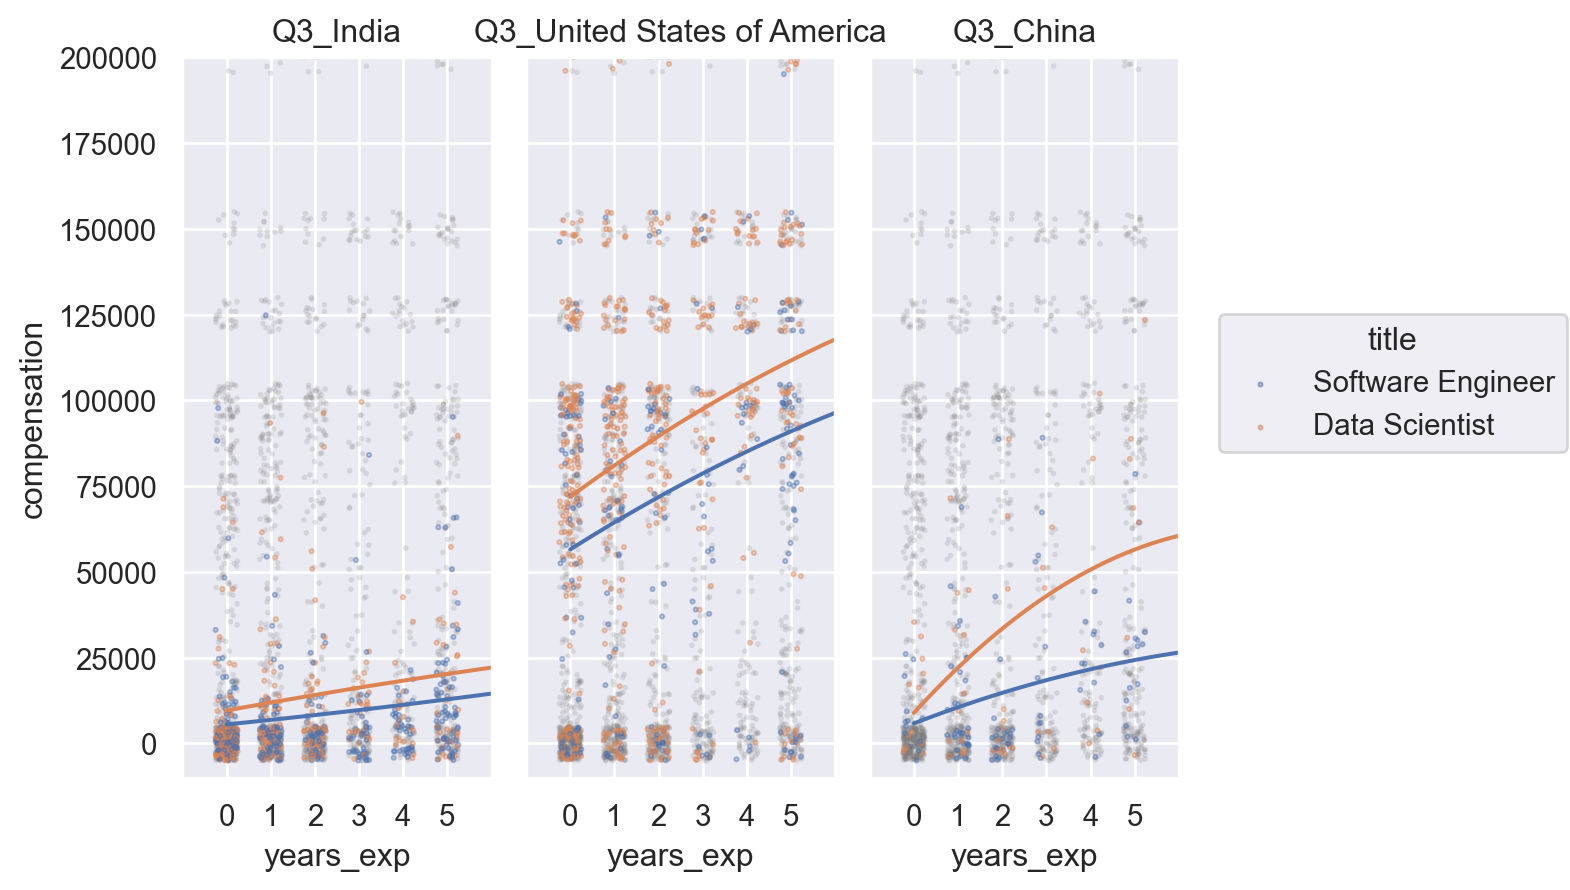

<Figure size 800x400 with 0 Axes>

In [23]:
fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_train
       #.query('compensation < 200_000 and years_exp < 16')
       .assign(
         title=kag_y_train,
         country=(X_train
             .loc[:, 'Q3_United States of America': 'Q3_China']
             .idxmax(axis='columns')
            )
       ), x='years_exp', y='compensation', color='title')
 .facet('country')
 .add(so.Dots(alpha=.01, pointsize=2, color='grey' ), so.Jitter(x=.5, y=10_000), col=None)
 .add(so.Dots(alpha=.5, pointsize=1.5), so.Jitter(x=.5, y=10_000))
 .add(so.Line(pointsize=1), so.PolyFit(order=2))
 .scale(x=so.Continuous().tick(at=[0,1,2,3,4,5]))
 .limit(y=(-10_000, 200_000), x=(-1, 6))  # zoom in with this not .query (above)
#  .on(fig)  # not required unless saving to image
#  .plot()   # ditto
)

In [24]:
# (X_train
# .corr(method='spearman')
# .style
# .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
# .set_sticky(axis='index')
# .set_table_styles([
#     {'selector': 'th, td',
#      'props': [('font-size', '7pt')]
#     }])
# )

# Tree Creation

### Gini Coefficient

The Gini coefficient (also known as the Gini index or Gini impurity)1, quantifies the level of inequality in a frequency distribution. A value of 0 indicates complete equality, with all values being the same, and a value of 1 represents the maximum level of inequality among the values.
The formula for the Gini coefficient is:

$$\text{Gini} = 1- \sum_{i=1}^{C}p_i^2$$

Where Gini is the Gini index, $c$ is the number of classes, and $p_i$ is the proportion of observations that belong to class $i$.

In order to understand optimal splitting, we’ll simulate a dataset with two classes and one feature. For some values of the features, the classes will overlap—there will be observations from both classes on each side of any split.

We’ll find the threshold for which the feature best separates the data into the correct classes.
Let’s explore this by generating two random samples using NumPy. We will label one sample as Negative and the other as Positive. 

Here is a visualization of what the distributions look like:

In [25]:
import numpy as np
import numpy.random as rn

pos_center = 12  # Define the center value for positive data
pos_count = 100  # Define the number of positive data points
neg_center = 7  # Define the center value for negative data
neg_count = 1000  # Define the number of negative data points

# Create a random number generator with a specific seed for reproducibility
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))

# Generate data points with Gaussian (normal) distribution for positive and negative classes
# Positive data points: pos_center + random values from a standard normal distribution
# Negative data points: neg_center + random values from a standard normal distribution
# The np.append() function is used to concatenate the positive and negative data points into a single array
# The label 'pos' is assigned to each positive data point, and 'neg' is assigned to each negative data point
gini = pd.DataFrame({'value':
    np.append((pos_center) + rs.randn(pos_count),
              (neg_center) + rs.randn(neg_count)),
                     'label':
    ['pos']* pos_count + ['neg'] * neg_count})

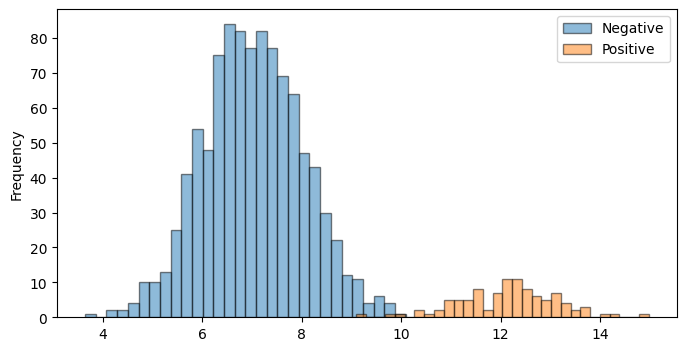

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
     .groupby('label')
     [['value']]
     .plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
    )

ax.legend(['Negative', 'Positive']);

Positive and negative distributions for Gini demonstration. Note that there are overlapping values between 9 and 10.

Now, let’s imagine that we needed to choose a value where we determine whether values are negative or positive. The Gini coefficient is a metric that can help with this task.

To calculate the Gini coefficient for our positive and negative data, we need to consider a point (my function calls it the split_point) where we decide whether a value is positive or negative. If we have the actual labels for the data, we can calculate the true positive, false positive, true negative, and false negative values. Then we calculate the weighted average of one minus the fraction of true and false positives squared. We also calculate the weighted average of one minus the fraction of true and false negatives squared. The weighted average of these two values is the Gini coefficient.

Here is a function that performs the calculation:

In [27]:
def calc_gini(df, val_col, label_col, pos_val, split_point,
              debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini impurity 
    is a measure of the probability of a random sample being classified 
    incorrectly when a feature is used to split the data. The lower the 
    impurity, the better the split.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data
    val_col (str): The column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents 
        the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
        impurities and the final weighted average

    Returns:
    float: The weighted average of Gini impurity for the positive and 
        negative subsets.
    """    
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) + \
                   gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
        
    return weighted_avg
        

In [28]:
# Let’s choose a split point and calculate the Gini coefficient (the weighted_avg value).
calc_gini(gini, val_col='value', label_col='label', pos_val='pos', split_point=9.24, debug=True)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

With the function in hand, let’s loop over the possible values for the split point and plot out the coefficients for a given split. If we go too low, we get too many false positives. Conversely, if we set the split point too high, we get too many false negatives, and somewhere in between lies the lowest Gini coefficient.

Text(0.5, 0, 'Split Point')

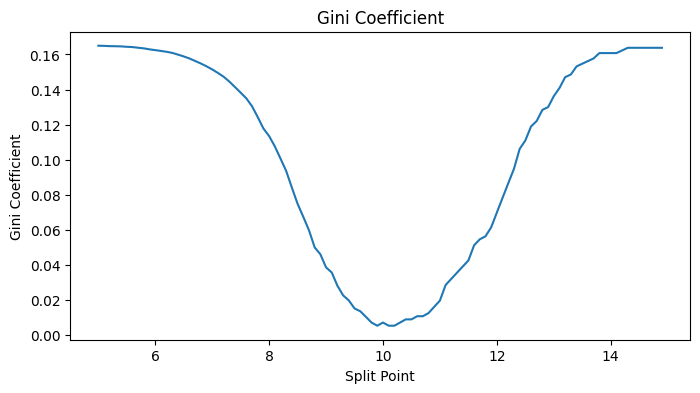

In [29]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
                           pos_val='pos', split_point=v))
fig, ax = plt.subplots(figsize=(8, 4))    
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

Armed with this graph, somewhere around 10 provides the lowest Gini coefficient. Let’s look at the values around 10

In [30]:
 pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

In [31]:
# This code verifies that the split point at 9.9 will minimize the Gini coefficient:
print(pd.DataFrame({'gini':ginis, 'split':values}).query('gini <= gini.min()'))

        gini  split
49  0.005429    9.9


## Coefficients in Trees

Now let’s make a simple tree that only has a single node. We call this a decision stump (because it has no branches).

We can use a DecisionTreeClassifier from scikit-learn. We will call the .fit method to fit the training data to the labels. Remember, we pass in a dataframe for the features and a series for the labels. (We can also pass in NumPy data structures but I find those inconvenient for tabular work.)

In [32]:
from sklearn import tree
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

DecisionTreeClassifier(max_depth=1)

A valuable decision tree feature is that you can visualize what they do. Below, we will create a visualization of the decision tree.

It shows a single decision at the top box (or node). It checks if the value less than or equal to 9.708. If that decision is true, we jump to the left child, the negative label. Otherwise, we use the right child, the positive label.

You can see that the base Gini value (given in the top box) is our starting Gini considering that we labeled everything as positive.

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos')]

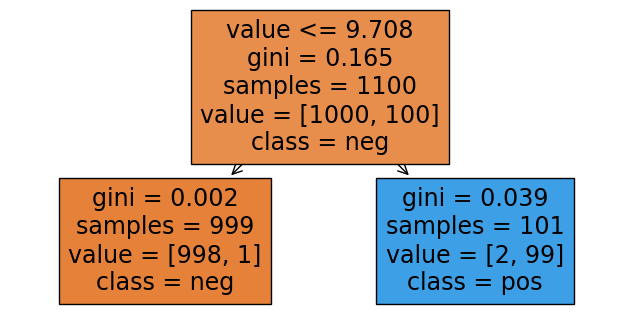

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value'],
               filled=True, 
               class_names=stump.classes_,
               ax=ax)

If you calculate the weighted average of the Gini coefficients in the leaf nodes, you see a value very similar to the minmum value we calculated above:

In [34]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999
total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + \
               gini_neg * (neg_size/total_size)
print(weighted_avg)

0.005397272727272727


XGBoost doesn’t use Gini, but Scikit-Learn does by default. XGBoost goes through a tree-building process. After training a tree, there are two statistics gig_i and hih_i. They are similar to Gini but also represent the behavior of the loss function. The gradient (gig_i) represents the first derivative of the loss function with respect to the predicted value for each instance, while the second derivative (hih_i) represents the curvature of the loss function.

Let’s make a stump in XGBoost by limiting the max_depth and n_estimators parameters:

In [35]:
import xgboost as xgb
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)                 
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [36]:
# The .plot_tree method will let us visualize the split point for the stump.
# xgb.plot_tree(xg_stump, num_trees=0)

In [37]:
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

In [38]:
# my_dot_export(xg_stump, num_trees=0, filename='img/stump_xg.dot', title='A demo stump')

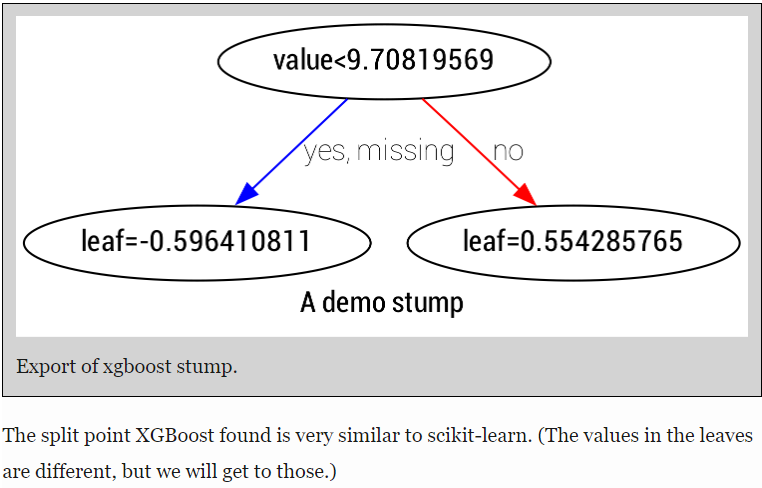

## Another Visualization Tool

The dtreeviz package creates visualizations for decision trees. It provides a clear visualization of tree structure and decision rules, making it easier to understand and interpret the model.

In [39]:
import dtreeviz

In [40]:
# viz = dtreeviz.model(xg_stump, X_train=gini[['value']], 
#                      y_train=gini.label=='pos',
#     target_name='positive',
#     feature_names=['value'], class_names=['negative', 'positive'],
#     tree_index=0)
# viz.view()

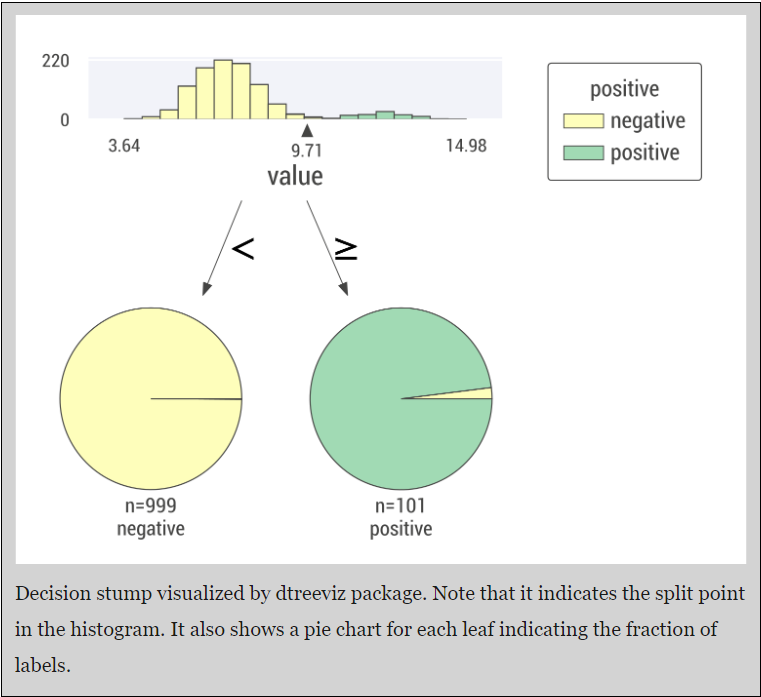

This visualization shows the distributions of the data as histograms. It also labels the split point. Finally, it shows what the ratios of the predictions are as pie charts.

## Summary 

The Gini coefficient is a measure of inequality used in economics and statistics. It is typically used to measure income inequality, but can also be applied to other variables such as wealth. The Gini coefficient takes on a value between 0 and 1, with 0 representing perfect equality (where everyone has the same income) and 1 representing perfect inequality (where one person has all the income and everyone else has none).

## Exercises

- What is the Gini coefficient?

- How is the Gini coefficient calculated?

- How is the Gini coefficient used in Decision trees?

- What does a stump tell us about the data?

# Stumps on Real Data

By now, you should have an intuition on how a decision tree “decides” values to split on. Decision trees use a greedy algorithm to split on a feature (column) that results in the most “pure” split.

Instead of looking at our simple data with only one column of information, let’s use the Kaggle data. We will predict whether someone is a data scientist or software engineer based on how they answered the survey questions. The decision tree should loop over every column and try to find the column and split point that best separates data scientists from software engineers. It will recursively perform this operation, creating a tree structure.

In [41]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
stump_dt.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'r <= 0.5\ngini = 0.496\nsamples = 2110\nvalue = [1153, 957]\nclass = Data Scientist'),
 Text(0.25, 0.25, 'gini = 0.493\nsamples = 1484\nvalue = [653, 831]\nclass = Software Engineer'),
 Text(0.75, 0.25, 'gini = 0.322\nsamples = 626\nvalue = [500, 126]\nclass = Data Scientist')]

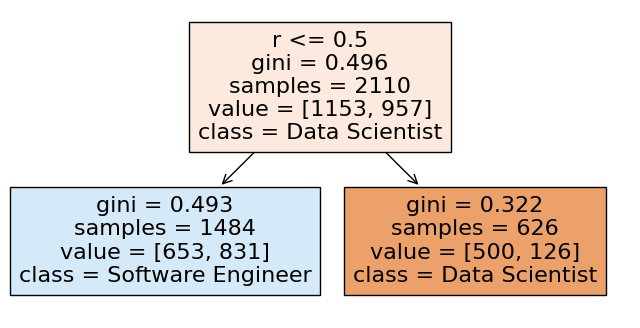

In [42]:
#Let’s explore how we decided to split the data. Here is the code to visualize the tree:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features, 
               filled=True, 
               class_names=stump_dt.classes_,
               ax=ax)

The column that best separates the two professions is the use of the R programming language. This seems like a sensible choice considering that very few software engineers use the R language.

We can evaluate the accuracy of our model with the .score method. We call this method on the holdout set. The holdout set (or validation set), X_test, is the portion of the data that is set aside and not used during the training phase, but instead is reserved for testing the model’s performance once it has been trained. It allows for a more accurate evaluation of the model’s performance against new data, as it is tested on unseen data.

It looks like this model classified 62% of the occupations correctly by just looking at a single column, the R column.

In [43]:
X_test = kag_pl.transform(kag_X_test)
stump_dt.score(X_test, kag_y_test)

0.6243093922651933

Is 62% accuracy good? Bad? The answer to questions like this is generally “it depends”. Looking at accuracy on its own is usually not sufficient to inform us of whether a model is “good enough”. However, we can use it to compare models. We can create a baseline model using the DummyClassifier. This classifier just predicts the most common label, in our case 'Data Scientist'. Not a particularly useful model, but it provides a baseline score that our model should be able to beat. If we can’t beat that model, we shouldn’t be using machine learning.

In [44]:
from sklearn import dummy
dummy_model = dummy.DummyClassifier()
dummy_model.fit(X_train, kag_y_train)
dummy_model.score(X_test, kag_y_test)

0.5458563535911602

The baseline performance is 54% accuracy (which is the percent of values that are 'Data Scientist'). Our stump accuracy is better than the baseline. Note that being better than the baseline does not qualify a model as “good”. But it does indicate that model is potentially useful.

# Decision Stump with XGBoost

XGBoost does not use the Gini calculation to decide how to make decisions. Rather XGBoost uses boosting and gradient descent. Boosting is using a model and combining it with other models to improve the results. In fact, XGBoost stands for eXtreme Gradient Boosting. The “extreme” part is due to the ability to regularize the result and the various optimizations is has to efficiently create the model.

In this case, the subsequent models are trained from the error of the previous model with the goal to reduce the error. The “gradient descent” part comes in because this process of minimizing the error is specified into an objective function such that the gradient descent algorithm can be applied. The outcome is based on the gradient of the error with respect to the prediction. The objective function combines two parts: training loss and a regularization term. Trees are created by splitting on features that move a small step in the direction of the negative gradient, which moves them closer to the global minimum of the loss function.

There are many parameters for controlling XGBoost. One of them is n_estimators, the number of trees. Let’s create a stump with XGBoost by setting this value to 1 and see if it performs similarly to the scikit-learn stump.

In [45]:
import xgboost as xgb
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
# kag_stump.fit(X_train, kag_y_train)

In [46]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
y_test[:5]

array([1, 0, 0, 1, 1])

The label encoder will return 1s and 0s. How do you know which numerical value is which string value? You can ask the label encoder for the .classes_. The index of these values is the number that the encoder uses.

In [47]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

Because 'Data Scientist' is in index 0 in .classes_, it is the 0 value in the training labels. The 1 represents 'Software Engineer'. This is also called the positive label. (It is the positive label because it has the value of 1.)

The label encoder has an .inverse_transform method that reverses the transformation. (This would require more effort if we went with the pandas encoding solution.)

In [48]:
label_encoder.inverse_transform([0, 1])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [49]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
kag_stump.fit(X_train, y_train)
kag_stump.score(X_test, y_test)

0.6243093922651933

It looks like the XGBoost stump performs similarly to the scikit-learn decision tree. Let’s visualize what it looks like.

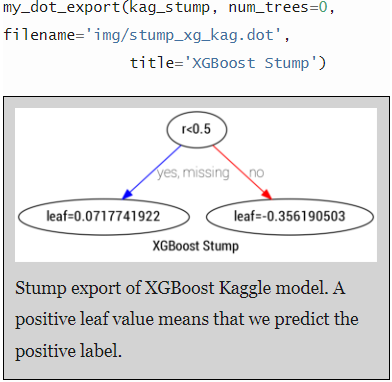

## Values in the XGBoost Tree

What are the numbers in the leaves of the export? They are probabilities. Well, actually, they are the logarithm of the odds of the positive value. Statisticians call this the logit.

When you calculate the inverse logit scores with the values from the nodes in the tree, you get the probability of the prediction. If a survey respondent does not use the R language, the leaf value is .0717741922. The inverse logit of that is .518, or 51.8%. Because this value is greater than .5, we assume the positive label or class of Software Engineer (the second value in kag_stump.classes_ is 1, which our label encoder used as the value for Software Engineer).

In [50]:
import numpy as np
def inv_logit(p: float) -> float:
    """
    Compute the inverse logit function of a given value.
    The inverse logit function is defined as:
        f(p) = exp(p) / (1 + exp(p))

    Parameters
    ----------
    p : float
        The input value to the inverse logit function.

    Returns
    -------
    float
        The output of the inverse logit function.
    """
    return np.exp(p) / (1 + np.exp(p))

In [51]:
# Let’s see what probability comes out when we pass in .07177.
inv_logit(.0717741922)

0.5179358489487103

It looks like it spits out 51.8%.

Conversely, the inverse logit of the right node is .411. Because this number is below .5, we do not classify it as the second option but rather choose Data Scientist.

**Note**

Note that if a user uses R, they have a higher likelihood of being a Data Scientist (1-.41 or 59%), than a Software Engineer who doesn’t use R (.518 or 52%). In other words, using R pushes one more toward Data Scientist than not using R pushes one toward Software Engineer.

In [52]:
inv_logit(-.3592)

0.41115323716754393

Here I plot the inverse logit function. You can see a crossover point at 0 on the x-axis. When the x values are above 0, the y value will be > .5 (Software Engineer). When they are below 0, the values will be < .5 (Data Scientist).

Text(-3, 0.4, 'Predict Negative')

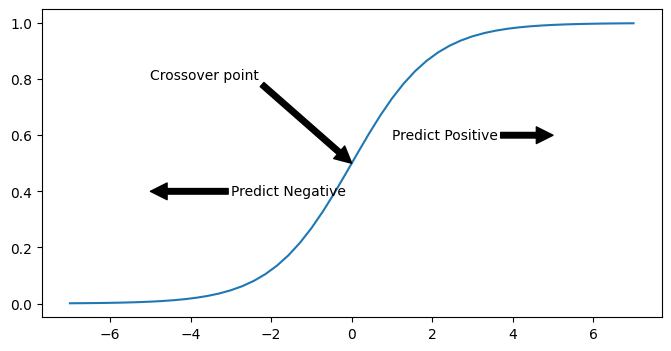

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
vals = np.linspace(-7, 7)
ax.plot(vals, inv_logit(vals))
ax.annotate('Crossover point', (0,.5), (-5,.8), arrowprops={'color':'k'}) 
ax.annotate('Predict Positive', (5,.6), (1,.6), va='center', arrowprops={'color':'k'}) 
ax.annotate('Predict Negative', (-5,.4), (-3,.4), va='center', arrowprops={'color':'k'})

The inverse logit function. When the x values are above 0, the y value will be > .5 (Software Engineer). When they are below 0, the values will be < .5 (Data Scientist).

## Summary


In this chapter, we explored making a stump on real data. A decision stump is a simple decision tree with a single split. We showed how we can use the XGBoost algorithm to create a decision stump. We also explored how the values in the leaves of XGBoost models indicate what label to predict.

# Model Complexity & Hyperparameters

In this chapter, we will explore the concept of underfit and overfit models. Then we will see how we can use hyperparameters, or attributes of the model to change the behavior of the model fitting.

## Underfit

A stump is too simple. Statisticians like to say it has too much bias. (I think this term is a little confusing and prefer “underfit”.) It has a bias towards simple predictions. In the case of our Kaggle model, the stump only looks at a single column. Perhaps it would perform better if it were able to also consider additional columns after looking at the R column.
When you have an underfit model, you want to make it more complex (because it is too simple). There are a few mechanisms we can use to add complexity:

- Add more features (columns) that have predictive value
- Use a more complex model

These are general strategies that work with most underfit models, not just trees.

Here is our stump. Let’s look at the accuracy (as reported by .score). It should be representative of an underfit model.

In [54]:
underfit = tree.DecisionTreeClassifier(max_depth=1)
X_train = kag_pl.fit_transform(kag_X_train)
underfit.fit(X_train, kag_y_train)
underfit.score(X_test, kag_y_test)

0.6243093922651933

# Growing a Tree

We showed how to create a stump. How do we fix our underfit stump? You could add more advanced features (or columns) to the training data that better separate the classes. Or we could make the stump more complex by letting the tree grow larger.

Instead of trying arbitrary tactics, generally, we want to proceed in a slightly more organized fashion. One common technique is to measure model  accuracy as you let the tree grow deeper (or add additional columns) and see if there is an improvement. You can optimize a scoring function given constraints. Different models can have different scoring functions. You can also create your own. We saw that scikit-learn optimizes Gini and that XGBoosts performs gradient descent on a loss function.

The constraints for the model are called hyperparameters. Hyperparameters, at a high level, are knobs that you can use to control the complexity of your model. Remember that our stump was too simple and underfit our data. One way we can add complexity to a tree-based model is to let it grow more nodes. We can use hyperparameters to determine how and when we will add nodes.

# Overfitting

Before optimizing our model, let’s look at the other end of the spectrum, an overfit model.

An overfit model is too complicated. Again, the statistician would say it has too much variance. I avoid using the term “variance” too much (unless I’m in an interview situation) and like to picture a model that looks at every nook and cranny of the data. When it sees an example that is new, the model compares all of these trivial aspects that the model learned by inspecting the training data, which tends to lead it down the wrong path. Rather than honing in on the right label, the complexity causes it to “vary”.

And again, there are general solutions to helping deal with overfitting:

- Simplify or constrain (regularize)
- Add more samples (rows of data)

For a tree model, we can prune back the growth so that the leaf nodes are overly specific. This will simplify or constrain the model. Alternatively, we can collect more data, thus forcing the model to have more attempts at finding the important features.

## Overfitting with Decision Trees

Let’s make an overfit model with a decision tree. This is quite easy. We just let the model grow until every node is pure (of the same class). We can set max_depth=None to overfit the tree, which is the default behavior of DecisionTreeClassifier.

In [56]:
# After we create the model, let’s inspect the accuracy.
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
X_train = kag_pl.fit_transform(kag_X_train)
hi_variance.fit(X_train, kag_y_train)
hi_variance.score(X_test, kag_y_test)

0.6651933701657459

In this case, the accuracy is 66%. The accuracy of the stump was 62%. It is possible (and likely) that we can get better accuracy than both the stump and the complex model by either simplifying our complex model or adding some complexity to our simple model.

Here is a visualization of the complex model. You can see that the tree is pretty deep. I count 22 levels of nodes. This visualization should help with the intuition of why an overfit tree is bad. It is essentially memorizing the training data. If you feed it data that is not exactly the same as data it has seen before, it will tend to go down the wrong track. (If you think memorizing the data is good, then you don’t need a machine learning model because you can just memorize every possible input and create a giant if statement for that.)

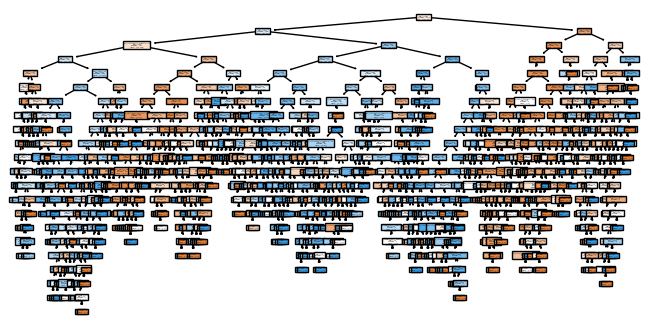

In [64]:
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True);

An overfit decision tree. This is too complicated and it is essentially memorizing the data that it was trained on. However, because it is very specific to the training data, it will tend to perform worse on data that it hasn’t seen before.

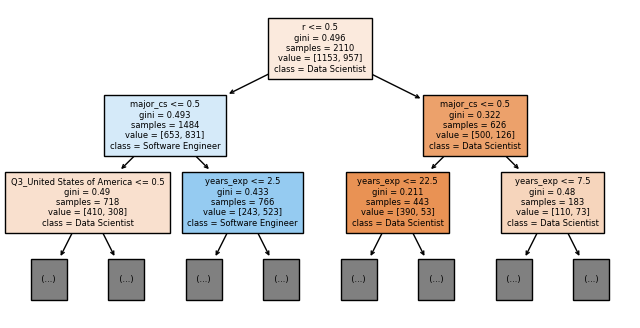

In [63]:
#Let’s zoom in on the top of the tree to understand more about what is happening.

fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(hi_variance, feature_names=features, filled=True, 
                  class_names=hi_variance.classes_,
                max_depth=2, fontsize=6);

The darker orange boxes tend towards more data scientists, and the bluer boxes are software engineers. If we go down the most orange path, at the top node is a person who uses R, who also didn’t study computer science, and finally, they have less or equal to 22.5 years of experience. Of folks who fall into this bucket, 390 of the 443 samples were data scientists.

The ability to interpret a decision tree is important and often business-critical. Many companies are willing to sacrifice model performance for the ability to provide a concrete explanation for the behavior of a model. A decision tree makes this very easy. We will see that XGBoost models prove more challenging at delivering a simple interpretation.

## Summary

In this chapter, the concept of underfit and overfit models is explored. Hyperparameters, or attributes of the model, are used to change the behavior of the model fitting. We saw that the max_depth hyperparameter can tune the model between simple and complex. An underfit model is too simple, having a bias towards simple predictions. To fix an underfit model, one can add more features or use a more complex model. These general strategies work with most underfit models, not just trees.

On the other hand, an overfit model is too complicated and has too much variance. To deal with overfitting, one can simplify or constrain the model, or add more samples. For a tree model, one can prune back the growth so that the leaf nodes are overly specific or collect more data. The goal is to find the optimal balance between a model that is too simple and too complex.

Later on, we will see that XGBoost creates decent models out of the box, but it also has mechanisms to tune the complexity. We will also see how you can diagnose overfitting by visualizing model performance.

# Tree Hyperparameters

Previously, we saw that models might be too complex or too simple. Some of the mechanisms for dealing with model complexity are by creating new columns (to deal with simple models) and adding more examples (to deal with complex models). But there are also levers that we can pull without dealing with data. These levers are hyperparameters, levers that change how the model is created, trained, or behaves.

## Decision Tree Hyperparameters

Let’s explore the hyperparameters of decision trees. You might wonder why we seem so concerned with decision trees when this book is about XGBoost. That is because decision trees form the basis for XGBoost. If you understand how decision trees work, that will aid your mental model of XGBoost. Also, many of the hyperparameters for decision trees apply to XGBoost at some level.

Many of the hyperparameters impact complexity (or simplicity). Here is a general rule for models based on scikit-learn. Hyperparameters that start with max_ will make the model more complex when you raise it. On the flip side, those that start with min_ will make the model simpler if you raise it. (The reverse is also true, they do the reverse when you lower them.)

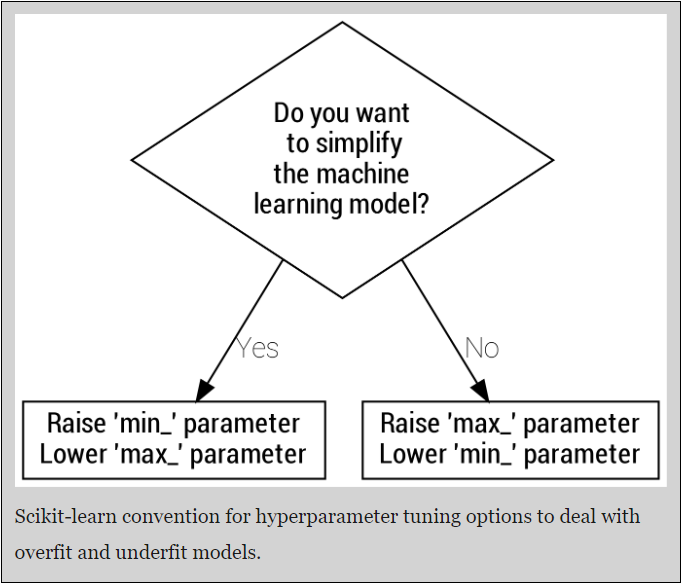

Here are the hyperparameters for scikit-learn’s DecisionTreeClassifier:

- **max_depth=None** - Tree depth. The default is to keep splitting until all nodes are pure or there are fewer than min_samples_split samples in each node. Range [1-large number].

- **max_features=None** - Amount of features to examine for the split. Default is the number of features. Range [1-number of features].

- **max_leaf_node=None** - Number of leaves in a tree. Range [1-large number].

- **min_impurity_decrease=0** - Split when impurity is >= this value. (Impurity : 0 - 100% accurate, .3 - 70%). Range [0.0-1.0]

- **min_samples_leaf=1**, - Minimum samples at each lea*. Range [1-large number]

- **min_samples_split=2** - Minimum samples required to split a node. Range [2-large number]

- **min_weight_fraction_leaf=0** - The fraction of the total weights required to be a leaf. Range [0-1]

To use a particular hyperparameter, you provide the parameter in the constructor before training a model. The constructor is the method called when a class is created. Then you train a model and measure a performance metric and track what happens to that metric as you change the parameter.

You can explore the parameters of a trained model as well using the .get_params method:

In [66]:
stump.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

We can verify that this is a stump because the max_depth hyperparameter is set to 1.

# Tracking changes with Validation Curves